In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import seaborn as sns

colors = ["#033270", "#1368aa", "#4091c9", "#9dcee2", "#fedfd4", "#f29479", "#f26a4f", "#ef3c2d", "#cb1b16", "#65010c"]

#Importing the data
df = pd.read_csv('online_retail-2010-2011.csv') # Veriyi okuma

# RFM

## Görev 1

In [2]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6,12/1/2010 8:34,4.25,13047.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Betimsel istatistiklerin kontrol edilmesi
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
df.isnull().sum() # Verideki eksik gözlemlerin kontrolü

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [6]:
df2 = df # Verinin kopyasını oluşturma

In [7]:
# Eksik gözlemlerin veri setinden çıkartılması

# df2.dropna(subset = ['Customer ID'], inplace=True)
df2 = df2[df2['Customer ID'].notna()]

In [8]:
df2.isnull().sum() # Verideki eksik gözlemlerin kontrolü

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [9]:
# İptal edilen işlemlerin veri setinden çıkartılması
def C_Checker(x):
    if x[0] == 'C':
        return 1
    else:
        return 0
    
df2['IsReturn'] = df2['Invoice'].apply(C_Checker)

df2 = df2[df2["IsReturn"] == 0]
df2 = df2.drop(columns=["IsReturn"])

In [10]:
# Negatif değerlerin yok edilmesi

df2 = df2[df2['Price'] > 0]
df2 = df2[df2['Quantity'] > 0]

df2.reset_index(inplace = True)

In [11]:
# Betimsel istatistiklerin yeniden kontrol edilmesi
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
index,397885.0,278463.557214,152771.244081,0.000,148334.00,284903.00,410075.00,541909.00
Quantity,397885.0,12.988208,179.331551,1.000,2.00,6.00,12.00,80995.00
Price,397885.0,3.116525,22.097861,0.001,1.25,1.95,3.75,8142.75
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


In [12]:
# Eşsiz ürün sayısı
df2['StockCode'].nunique()

3665

In [13]:
# Hangi üründen kaçar tane olduğu bilgisi

df2['StockCode'].value_counts()

85123A    2035
22423     1723
85099B    1618
84879     1408
47566     1396
          ... 
90190A       1
84387A       1
84857B       1
21310        1
84877A       1
Name: StockCode, Length: 3665, dtype: int64

In [14]:
# En çok satılan 5 ürünün elde edilmesi ve çoktan aza doğru sıralanması

tmp2=df2['StockCode'].value_counts().nlargest(5).rename_axis('StockCode').reset_index(name='Count')

tmp=df2[df2['StockCode'].isin(tmp2['StockCode'])]
tmp=tmp.groupby(['StockCode']).agg(
                Description=pd.NamedAgg(column='Description',aggfunc='last'),
                Price=pd.NamedAgg(column='Price',aggfunc='last'))

tmp=pd.merge(tmp2, tmp, on = "StockCode")
tmp

,StockCode,Count,Description,Price
0,85123A,2035,CREAM HANGING HEART T-LIGHT HOLDER,2.95
1,22423,1723,REGENCY CAKESTAND 3 TIER,12.75
2,85099B,1618,JUMBO BAG RED RETROSPOT,2.08
3,84879,1408,ASSORTED COLOUR BIRD ORNAMENT,1.69
4,47566,1396,PARTY BUNTING,4.95


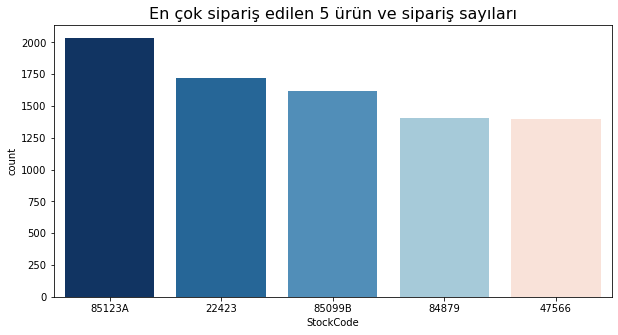

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize = (10,5))
sns.countplot(df2["StockCode"], palette=colors, order = df2["StockCode"].value_counts().nlargest(5).index)
plt.title("En çok sipariş edilen 5 ürün ve sipariş sayıları", fontsize = 16)
plt.show()

In [16]:
# Toplam kazancı ifade eden TotalPrice değişkeninin Invoice bazlı elde edilmesi
df2['TotalPrice'] = df2['Price'] * df2['Quantity']

tmp = df2.groupby(['Invoice']).agg(
                InvoiceDate = pd.NamedAgg(column='InvoiceDate',aggfunc='last'),
                TotalPrice = pd.NamedAgg(column='TotalPrice',aggfunc='sum'))

tmp = tmp.sort_values(by=['TotalPrice'], ascending=False)
tmp

,InvoiceDate,TotalPrice
Invoice,,
581483,12/9/2011 9:15,168469.60
541431,1/18/2011 10:01,77183.60
556444,6/10/2011 15:28,38970.00
567423,9/20/2011 11:05,31698.16
556917,6/15/2011 13:37,22775.93
...,...,...
539645,12/20/2010 16:03,0.95
540945,1/12/2011 12:41,0.85
542736,1/31/2011 15:37,0.55


## Görev 2

In [17]:
# Gerekli veri tipi değişikliklerinin yapılması
df2["Customer ID"] = df2["Customer ID"].astype(int)
df2['InvoiceDate']= df2['InvoiceDate'].astype('datetime64[ns]')

# Verinin InvoiceDate bazında sıralandığına emin olmak
df2 = df2.sort_values(by=['InvoiceDate'], ascending=True)


d = datetime(2011, 12, 11) # Recency hesabı için "bugün" olarak tanımlanan tarihin tanımlanması



df2["Recency"] = d - df2["InvoiceDate"] # Recency değerinin her bir row için hesaplanması

def day_diff_calc(x): 
    return x.days

df2["Recency"] = df2["Recency"].apply(day_diff_calc) # Sonucun formatının uygun hale getirilmesi

# df2 = df2.drop(columns=["index"])
df2.head(10)

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Recency
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,374
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,374
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,374
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,374
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,374
5,5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,374
6,6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,374
7,7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,374
8,8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,374
24,24,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047,United Kingdom,31.80,374


In [18]:
# Recency, Frequency ve Monetary metriklerinin hesaplanması

df_rfm = df2.groupby(['Customer ID'], as_index=False).agg(
               Recency = pd.NamedAgg(column = 'Recency',aggfunc = 'last'),
               Frequency = pd.NamedAgg(column = 'Invoice',aggfunc = 'count'),  
               Monetary = pd.NamedAgg(column = 'TotalPrice',aggfunc = 'sum'))

# Veri setini "monetary  > 0" olacak şekilde filtreleme
df_rfm = df_rfm[df_rfm["Monetary"] > 0]
df_rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24
3,12349,19,73,1757.55
4,12350,311,17,334.40
5,12352,37,85,2506.04
6,12353,205,4,89.00
7,12354,233,58,1079.40
8,12355,215,13,459.40
9,12356,23,59,2811.43


## Görev 3

In [19]:
# Recency, Frequency ve Monetary metriklerin qcut yardımı ile 5 aralığa bölünmesi
df_rfm["recency_score"] = pd.qcut(df_rfm['Recency'], q = 5)
df_rfm["frequency_score"] = pd.qcut(df_rfm['Frequency'], q = 5)
df_rfm["monetary_score"] = pd.qcut(df_rfm['Monetary'], q = 5)


print("Recency Score --> ", df_rfm["recency_score"].unique())
print(" ")
print("Frequency Score --> ",df_rfm["frequency_score"].unique())
print(" ")
print("Monetary Score --> ",df_rfm["monetary_score"].unique())

Recency Score -->  [(180.0, 374.0], (0.999, 13.8], (72.0, 180.0], (13.8, 33.0], (33.0, 72.0]]
Categories (5, interval[float64]): [(0.999, 13.8] < (13.8, 33.0] < (33.0, 72.0] < (72.0, 180.0] < (180.0, 374.0]]
 
Frequency Score -->  [(0.999, 14.0], (121.0, 7847.0], (29.0, 58.0], (58.0, 121.0], (14.0, 29.0]]
Categories (5, interval[float64]): [(0.999, 14.0] < (14.0, 29.0] < (29.0, 58.0] < (58.0, 121.0] < (121.0, 7847.0]]
 
Monetary Score -->  [(2058.426, 280206.02], (942.276, 2058.426], (250.194, 490.096], (3.749, 250.194], (490.096, 942.276]]
Categories (5, interval[float64]): [(3.749, 250.194] < (250.194, 490.096] < (490.096, 942.276] < (942.276, 2058.426] < (2058.426, 280206.02]]


In [20]:
# Aralıkların recency_score, frequency_score ve monetary_score olarak kaydedilmesi

df_rfm['recency_score'] = df_rfm['recency_score'].astype(str)
df_rfm['frequency_score'] = df_rfm['frequency_score'].astype(str)
df_rfm['monetary_score'] = df_rfm['monetary_score'].astype(str)

def rec_one_to_five(x):
    if x == "(0.999, 13.8]":
        return "5"
    elif x == "(13.8, 33.0]":
        return "4"
    elif x == "(33.0, 72.0]":
        return "3"
    elif x == "(72.0, 180.0]":
        return "2"
    else:
        return "1"

def fre_one_to_five(x):
    if x == "(0.999, 14.0]":
        return "1"
    elif x == "(14.0, 29.0]":
        return "2"
    elif x == "(29.0, 58.0]":
        return "3"
    elif x == "(58.0, 121.0]":
        return "4"
    else:
        return "5"
    
def mon_one_to_five(x):
    if x == "(3.749, 250.194]":
        return "1"
    elif x == "(250.194, 490.096]":
        return "2"
    elif x == "(490.096, 942.276]":
        return "3"
    elif x == "(942.276, 2058.426]":
        return "4"
    else:
        return "5"
    

df_rfm['recency_score'] = df_rfm['recency_score'].apply(rec_one_to_five)
df_rfm['frequency_score'] = df_rfm['frequency_score'].apply(fre_one_to_five)
df_rfm['monetary_score'] = df_rfm['monetary_score'].apply(mon_one_to_five)

df_rfm.head(10)

,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
0,12346,326,1,77183.60,1,1,5
1,12347,3,182,4310.00,5,5,5
2,12348,76,31,1797.24,2,3,4
3,12349,19,73,1757.55,4,4,4
4,12350,311,17,334.40,1,2,2
5,12352,37,85,2506.04,3,4,5
6,12353,205,4,89.00,1,1,1
7,12354,233,58,1079.40,1,3,4
8,12355,215,13,459.40,1,1,2
9,12356,23,59,2811.43,4,4,5


In [21]:
# recency_score ve frequency_score’un tek bir değişken olarak ifade edilmesi ve RFM_SCORE olarak kaydedilmesi
def rfm_calc(row):
    r = row["recency_score"]
    f = row["frequency_score"]
    
    return r + f

df_rfm["RFM_SCORE"] = df_rfm.apply(rfm_calc, axis=1)
               
df_rfm.head(10)

,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346,326,1,77183.60,1,1,5,11
1,12347,3,182,4310.00,5,5,5,55
2,12348,76,31,1797.24,2,3,4,23
3,12349,19,73,1757.55,4,4,4,44
4,12350,311,17,334.40,1,2,2,12
5,12352,37,85,2506.04,3,4,5,34
6,12353,205,4,89.00,1,1,1,11
7,12354,233,58,1079.40,1,3,4,13
8,12355,215,13,459.40,1,1,2,11
9,12356,23,59,2811.43,4,4,5,44


In [22]:
# Bizle paylaşılan segmentation map
seg_map = {
r'[1-2][1-2]' : 'hibernating',
r'[1-2][3-4]' : 'at_Risk',
r'[1-2]5' : 'cant_loose',
r'3[1-2]' : 'about_to_sleep',
r'33' : 'need_attention',
r'[3-4][4-5]': 'loyal_customers',
r'41' : 'promising',
r'51' : 'new_customers',
r'[4-5][2-3]' : 'potential_loyalists',
r'5[4-5]' : 'champions'
}

In [23]:
# seg_map yardımı ile skorların segmentlere çevrilmesi
def customer_seg_func(row):
    if ((row['recency_score'] == "1" or row['recency_score'] == "2") and
        (row['frequency_score'] == "1" or row['frequency_score'] == "2")):
            return ('hibernating')
        
    elif ((row['recency_score'] == "1" or row['recency_score']=="2") and
          (row['frequency_score']=="3" or row['frequency_score']=="4")):
            return ('at_Risk')
        
    elif ((row['recency_score'] == "1" or row['recency_score'] == "2") and
          (row['frequency_score'] == "5")):
            return ('cant_loose')
        
    elif ((row['recency_score'] == "3") and
          (row['frequency_score'] == "1" or row['frequency_score'] == "2")):
            return ('about_to_sleep')
        
    elif ((row['recency_score'] == "3") and
          (row['frequency_score'] == "3")):
            return ('need_attention')
        
    elif ((row['recency_score'] == "3" or row['recency_score'] == "4") and
          (row['frequency_score'] == "5" or row['frequency_score'] == "4")):
            return ('loyal_customers')
        
    elif ((row['recency_score'] == "4") and
          (row['frequency_score'] == "1")):
            return ('promising')
        
    elif ((row['recency_score'] == "5") and
          (row['frequency_score'] == "1")):
            return ('new_customers')
        
    elif ((row['recency_score'] == "5" or row['recency_score'] == "4") and
          (row['frequency_score'] == "3" or row['frequency_score'] == "2")):
            return ('potential_loyalists')
        
    elif ((row['recency_score'] == "5") and
          (row['frequency_score'] == "4" or row['frequency_score'] == "5")):
            return ('champions')
        
    else: 
            return ('undefined')

df_rfm["customer_segment"] = df_rfm.apply(customer_seg_func, axis = 1)
df_rfm.head(10)

,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,customer_segment
0,12346,326,1,77183.60,1,1,5,11,hibernating
1,12347,3,182,4310.00,5,5,5,55,champions
2,12348,76,31,1797.24,2,3,4,23,at_Risk
3,12349,19,73,1757.55,4,4,4,44,loyal_customers
4,12350,311,17,334.40,1,2,2,12,hibernating
5,12352,37,85,2506.04,3,4,5,34,loyal_customers
6,12353,205,4,89.00,1,1,1,11,hibernating
7,12354,233,58,1079.40,1,3,4,13,at_Risk
8,12355,215,13,459.40,1,1,2,11,hibernating
9,12356,23,59,2811.43,4,4,5,44,loyal_customers


In [24]:
# Veri setinde hangi segmentten kaç tane müşteri olduğunun gösterimi
df_rfm["customer_segment"].value_counts()

hibernating            1074
loyal_customers         817
champions               606
at_Risk                 569
potential_loyalists     492
about_to_sleep          322
need_attention          205
promising               112
cant_loose               84
new_customers            57
Name: customer_segment, dtype: int64

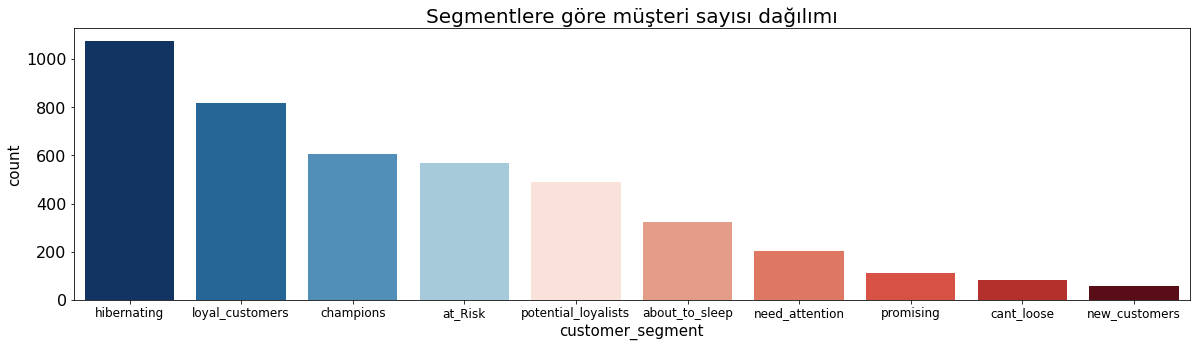

In [25]:
#Segmentlere göre müşteri sayısı dağılımı

plt.figure(figsize = (20, 5))
sns.countplot(df_rfm["customer_segment"], palette=colors, order = df_rfm["customer_segment"].value_counts().index)

plt.title("Segmentlere göre müşteri sayısı dağılımı", fontsize = 20)

plt.xticks(rotation = 0, fontsize=12)
plt.yticks(fontsize = 16)

plt.xlabel('customer_segment', fontsize = 15)
plt.ylabel('count', fontsize = 15)

plt.show()

Text(0.5, 1.0, 'Distribution of Segments')

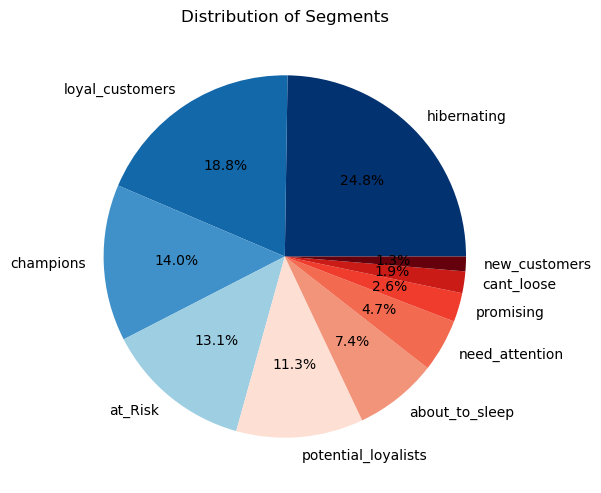

In [26]:
#Segmentlere göre yüzdelik dağılım

tmp = df_rfm.groupby(['customer_segment']).agg({'customer_segment' : 'count'})
tmp = tmp['customer_segment'].sort_values(ascending=False)

plt.figure(figsize = (6, 6), dpi = 100)

plt.pie(tmp, labels = tmp.index, colors = colors, autopct = '%1.1f%%', textprops = {'fontsize': 10})
plt.title("Distribution of Segments", color = 'black', fontsize = 12)

In [27]:
# Müşteri segmentlerinin Recency, Frequency ve Monetary bazında betimsel istatistikleri
df_rfm.groupby('customer_segment').agg({
'Recency': ['mean', 'min', 'max', 'count'],
'Frequency': ['mean', 'min', 'max', 'count'],
'Monetary': ['mean', 'min', 'max', 'count']})

Recency                  Frequency                   \
                           mean min  max count        mean  min   max count   
customer_segment                                                              
about_to_sleep        53.192547  34   72   322   15.987578    1    29   322   
at_Risk              166.435852  73  374   569   56.859402   30   119   569   
cant_loose           144.226190  73  373    84  181.642857  122   543    84   
champions              6.400990   1   13   606  288.998350   59  7847   606   
hibernating          210.251397  73  374  1074   13.585661    1    29  1074   
loyal_customers       34.206854  15   72   817  157.106487   59  1204   817   
need_attention        52.985366  34   72   205   41.731707   30    58   205   
new_customers          7.421053   1   12    57    7.578947    1    14    57   
potential_loyalists   16.668699   1   33   492   34.939024   15    58   492   
promising             23.437500  15   33   112    7.758929    1    14   112   

                        Monetary                           
                            mean     min        max count  
customer_segment                                           
about_to_sleep        450.997174    6.20    7330.80   322  
at_Risk               996.916872   67.23   11072.67   569  
cant_loose           2370.705012  411.53   10254.18    84  
champions            6960.915446  190.19  280206.02   606  
hibernating           536.535672    3.75   77183.60  1074  
loyal_customers      2845.732852  155.37  124914.53   817  
need_attention        856.195854   97.97   11581.80   205  
new_customers        3618.697018   41.99  168472.50    57  
potential_loyalists   915.486994   68.84   26879.04   492  
promising             429.433929   20.80    6748.80   112

In [ ]:
#Recency:champions, new_customers
#Frequency: champions, cant_loose
#Monetary: champions, new_customers

#hibernating: Yeni müşteri kazanmak, mevcut müşteriyi elde tutmaya göre yaklaşık 
#3-4 kat fazla maaliyetli olduğu için veri setimizin yaklaşık %25'ini oluşturan hibernating segmenti en önemli müşteri segmentlerinden biridir.
#Bu segmenti tekrar aktive etmek için aksiyon alınabilir. Bu segmente dahil müşteriler uzun zamandır alışveriş yapmayan ve en kalabalık gruptur.
#Bu gruptaki müşterileri geri kazanmak için neden tekrar alışveriş yapmadıklarının kontrol edilmesi gerekebilir.

#loyal_customers: Bu segmenteki müşteriler champion segmentindeki müşteriler kadar değerlidir. Sadece şampiyonlara değer vermenin
#yanında bu gruba da ilgi göstermek gerekir. Bu segmentteki müşteriler kolaylıkla champion segmentine çıkabilir veya zaten o
#segmentten buraya gelmiş olabilir. Bu segmentteki müşteriler düzenli alım yaparkensadece yakın tarihte alışveriş yapmamıştır.
#loyal customer'daki müşterilere doğru strateji ile yakın zamanda kolaylıkla alışveriş yaptırılabilir.

#cant_loose: Bu segmentteki müşteriler alışveriş frekansı yüksek ancak uzun zamandır alışveriş yapmamış müşterilerdir. 
#Bu müşteriler kaybedilmeye yakın ancak kaybedilmemesi gereken müşterilerdir. Bu segmentten feedback almak oldukça değerlidir.
#Bu müşteriyi geri kazanmak hem potansiyel ciro hem de sadık müşteri kazanmak anlamına gelmektedir. Bu segmentteki müşteriyi
#geri kazanmak champion segmentini genişletmek anlamına da gelmektedir.

## Görev 5

In [28]:
# Loyal Customers segmentine ait müşterilerin filtrelenmesi ve Customer ID bilgilerinin Excel'e kaydedilmesi
tmp= df_rfm[df_rfm["customer_segment"] == "loyal_customers"] 
tmp[["Customer ID","customer_segment" ]].to_excel("loyal_customers.xlsx")

# k-Means Clustering

In [29]:
#k-MEans uygulamak için yeni bir tablo oluşturluması

df_kmeans = df_rfm[["Customer ID", "Recency", "Frequency"]]
df_kmeans.index = df_kmeans["Customer ID"]
df_kmeans = df_kmeans.drop(columns = ["Customer ID"])
df_kmeans.head(10)

,Recency,Frequency
Customer ID,,
12346,326,1
12347,3,182
12348,76,31
12349,19,73
12350,311,17
12352,37,85
12353,205,4
12354,233,58
12355,215,13


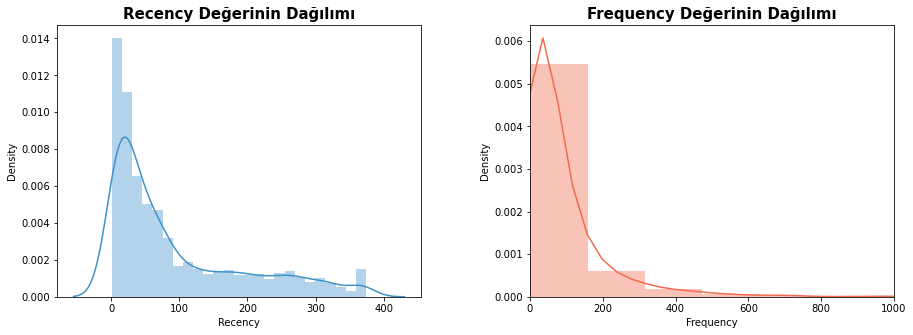

In [30]:
#Recency ve Frequency dağılımını inceleme

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.distplot(df_kmeans["Recency"], color = "#4091c9")
plt.title('Recency Değerinin Dağılımı', fontsize = 15, fontweight="bold")
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.distplot(df_kmeans["Frequency"], color = "#f26a4f")
plt.title('Frequency Değerinin Dağılımı', fontsize = 15, fontweight="bold")
plt.ylabel('Density')
plt.xlim(0, 1000) # Görselliği bozmamak için frequency 1000 ile limitlendi.

#fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.show()

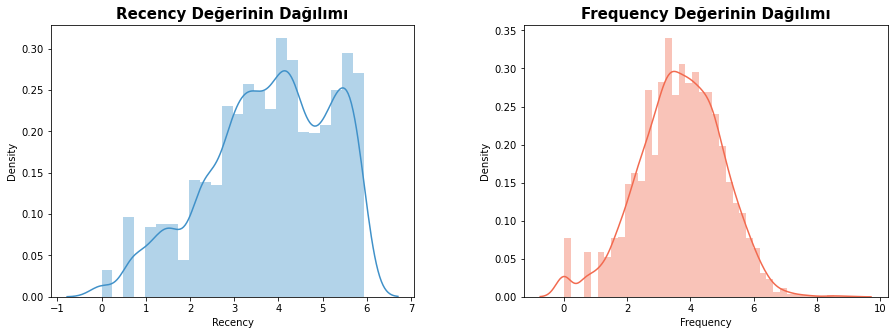

In [31]:
#Skewness'tan kurtulmak için normalizasyon yapılması ve görselleştirilmesi

log_rec = np.log(df_kmeans["Recency"])
log_fre = np.log(df_kmeans["Frequency"])

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.distplot(log_rec, color = "#4091c9")
plt.title('Recency Değerinin Dağılımı', fontsize = 15, fontweight="bold")
plt.ylabel('Density')


plt.subplot(1, 2, 2)
sns.distplot(log_fre, color = "#f26a4f")
plt.title('Frequency Değerinin Dağılımı', fontsize = 15, fontweight="bold")
plt.ylabel('Density')


#fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.show()

In [32]:
#Normalize olmuş değerlerin tabloya aktarılması

df_log = df_kmeans
df_log["Recency"] = log_rec
df_log["Frequency"] = log_fre
df_log

,Recency,Frequency
Customer ID,,
12346,5.786897,0.000000
12347,1.098612,5.204007
12348,4.330733,3.433987
12349,2.944439,4.290459
12350,5.739793,2.833213
...,...,...
18280,5.627621,2.302585
18281,5.198497,1.945910
18282,2.079442,2.484907


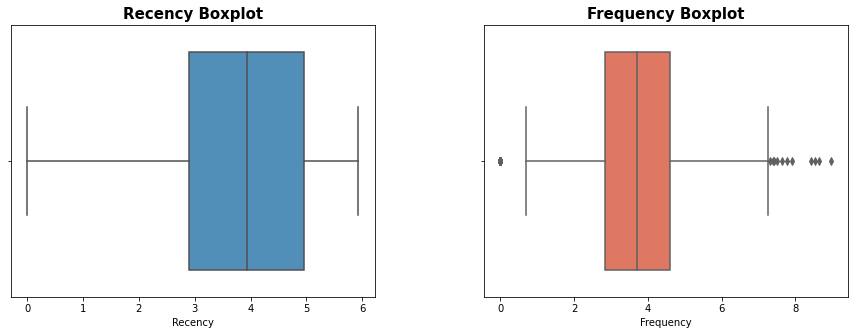

In [33]:
#Frequency ve Recency için boxplot grafiği çizdirilmesi

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x = "Recency", y = None, data=df_log, color = "#4091c9")
plt.title('Recency Boxplot', fontsize = 15, fontweight = "bold")

plt.subplot(1, 2, 2)
sns.boxplot(x = "Frequency", y = None, data = df_log, color = "#f26a4f")
plt.title('Frequency Boxplot', fontsize = 15, fontweight = "bold")

#fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)
plt.show()

In [34]:
#Aykırı değerlerin baskılanması

Q1 = df_log["Frequency"].quantile(0.25)
Q3 = df_log["Frequency"].quantile(0.75)
IQR = Q3-Q1
 
alt_sinir = Q1- 1.5*IQR
ust_sinir = Q3 + 1.5*IQR
 
outliers_pos =(df_log["Frequency"] > ust_sinir)  
outliers_neg = (df_log["Frequency"] < alt_sinir)

df_log[outliers_pos] = ust_sinir
df_log[outliers_neg] = alt_sinir

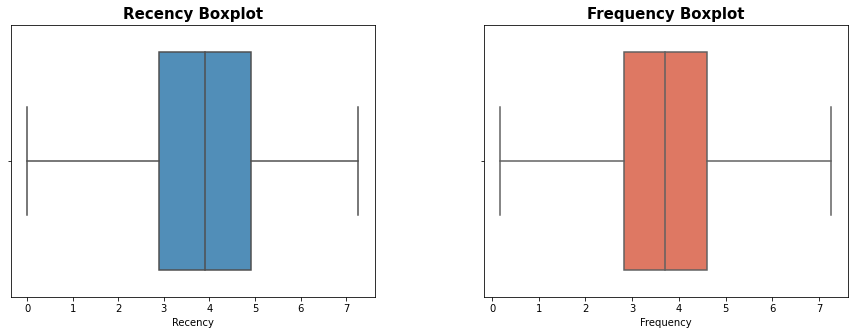

In [35]:
#Aykırı değerlerin baskılanmasından sonra boxplot grafiği çizdirilmesi

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x = "Recency", y = None, data = df_log, color = "#4091c9")
plt.title('Recency Boxplot', fontsize = 15, fontweight = "bold")

plt.subplot(1, 2, 2)
sns.boxplot(x = "Frequency", y = None, data = df_log, color = "#f26a4f")
plt.title('Frequency Boxplot', fontsize = 15, fontweight = "bold")

#fig.tight_layout()
plt.subplots_adjust(wspace = 0.3)
plt.show()

In [36]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

#1. elbow metodunun uygulanması

distortions = []
inertias = [] #sum of the distances from each data point to it's assigned cluster centroid.
mapping1 = {}
mapping2 = {} 
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters = k).fit(df_log)
    kmeanModel.fit(df_log)
 
    distortions.append(sum(np.min(cdist(df_log, kmeanModel.cluster_centers_,
                                        'euclidean'), axis = 1)) / df_log.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(df_log, kmeanModel.cluster_centers_,
                                   'euclidean'), axis = 1)) / df_log.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [37]:
#Her bir inertia değerinin yazdırılması

for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 16554.463535139228
2 : 9182.69676351592
3 : 6930.853660497378
4 : 5144.64278287205
5 : 4231.745180019675
6 : 3420.1789201363663
7 : 2959.3093556758913
8 : 2581.959921298434
9 : 2248.905894022938


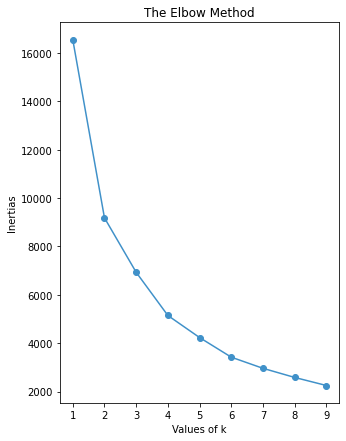

In [38]:
# Elbow metodunun grafiğinin çizdirilmesi

plt.figure(figsize = (5, 7))
plt.plot(K, inertias, 'bo-', color = "#4091c9")

plt.xlabel('Values of k')
plt.ylabel('Inertias')
plt.title('The Elbow Method')

plt.show()

Text(0, 0.5, ' Sum of Squared Distances')

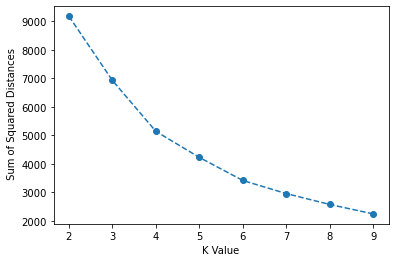

In [39]:
# 2. Elbow metodunun uygulanması

ssd = []

for k in range(2,10):
    
    model = KMeans(n_clusters=k)
    
    
    model.fit(df_log)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)
    
plt.plot(range(2,10),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

In [40]:
# Uzaklık değişim farklılıkları

ssd

[9182.701545673286,
 6930.864623863203,
 5144.6395255578445,
 4230.134538462926,
 3420.6976835895775,
 2960.787609131238,
 2579.3123350932838,
 2248.02179594438]

In [41]:
# SSD değerleri arasındaki farkın yazdırılması
pd.Series(ssd).diff()

0            NaN
1   -2251.836922
2   -1786.225098
3    -914.504987
4    -809.436855
5    -459.910074
6    -381.475274
7    -331.290539
dtype: float64

In [42]:
#Seçilen n_cluster değerine göre modelin fit edilmesi

kmeans = KMeans(n_clusters = 4)
k_fit = kmeans.fit(df_log)

Text(0.5, 1.0, 'Clusterların Recency ve Frequency bazlı Dağılımı')

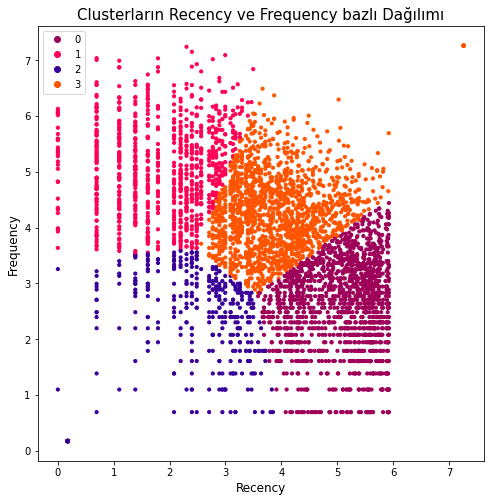

In [46]:
#k-Means algoritma çıktısının grafikleştirilmesi

cmap = LinearSegmentedColormap.from_list(name = 'tmp',
                                         colors = ["#9e0059", "#ff0054", "#390099", "#ff5400"])

kumeler = k_fit.labels_
df_log["cluster"] = kumeler

plt.figure(figsize = (8, 8))

scatter = plt.scatter(df_log["Recency"], df_log["Frequency"], c = df_log["cluster"], s = 10, cmap = cmap)
plt.legend(handles = scatter.legend_elements()[0], labels = [0, 1, 2, 3])

plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Recency', fontsize = 12)
plt.title('Clusterların Recency ve Frequency bazlı Dağılımı', fontsize = 15)

#merkezler = k_fit.cluster_centers_

#plt.scatter(merkezler[:,0], merkezler[:,1], c = "black", s = 200, alpha = 0.8);

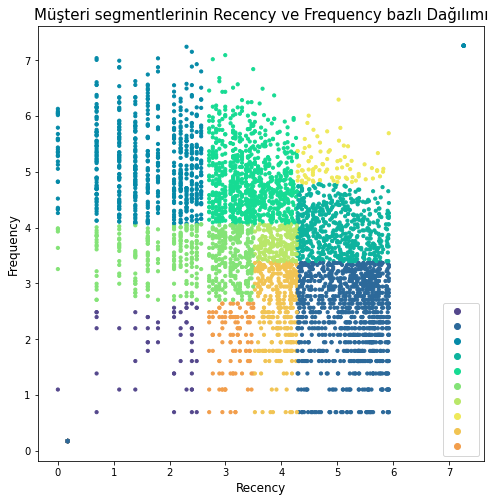

In [47]:
#RFM model çıktısının grafikleştirilmesi

cmap = LinearSegmentedColormap.from_list(name = 'tmp',
                                         colors = ["#54478c", "#2c699a", "#048ba8", "#0db39e", "#16db93",
                                                  "#83e377", "#b9e769", "#efea5a", "#f1c453", "#f29e4c"])

df_new = df_log

df_new = df_new.merge(df_rfm, left_on = "Customer ID", right_on = "Customer ID", how = "left")

scale_mapper = {"new_customers" : 0, "hibernating" : 1, "champions" : 2, "at_Risk" : 3,
                "loyal_customers" : 4, "potential_loyalists" : 5, "need_attention" : 6,
                "cant_loose" : 7, "about_to_sleep" : 8, "promising" : 9}

df_new["customer_segment"] = df_new["customer_segment"].replace(scale_mapper)

plt.figure(figsize = (8, 8))

plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Recency', fontsize = 12)
plt.title('Müşteri segmentlerinin Recency ve Frequency bazlı Dağılımı', fontsize = 15)

scatter = plt.scatter(df_new["Recency_x"], df_new["Frequency_x"], c = df_new["customer_segment"], s = 10, cmap = cmap)
plt.legend(handles = scatter.legend_elements()[0])

Text(0.5, 1.0, 'RFM ve kMeans Sonuçlarının Heatmap vasıtasıyla Kıyaslanması')

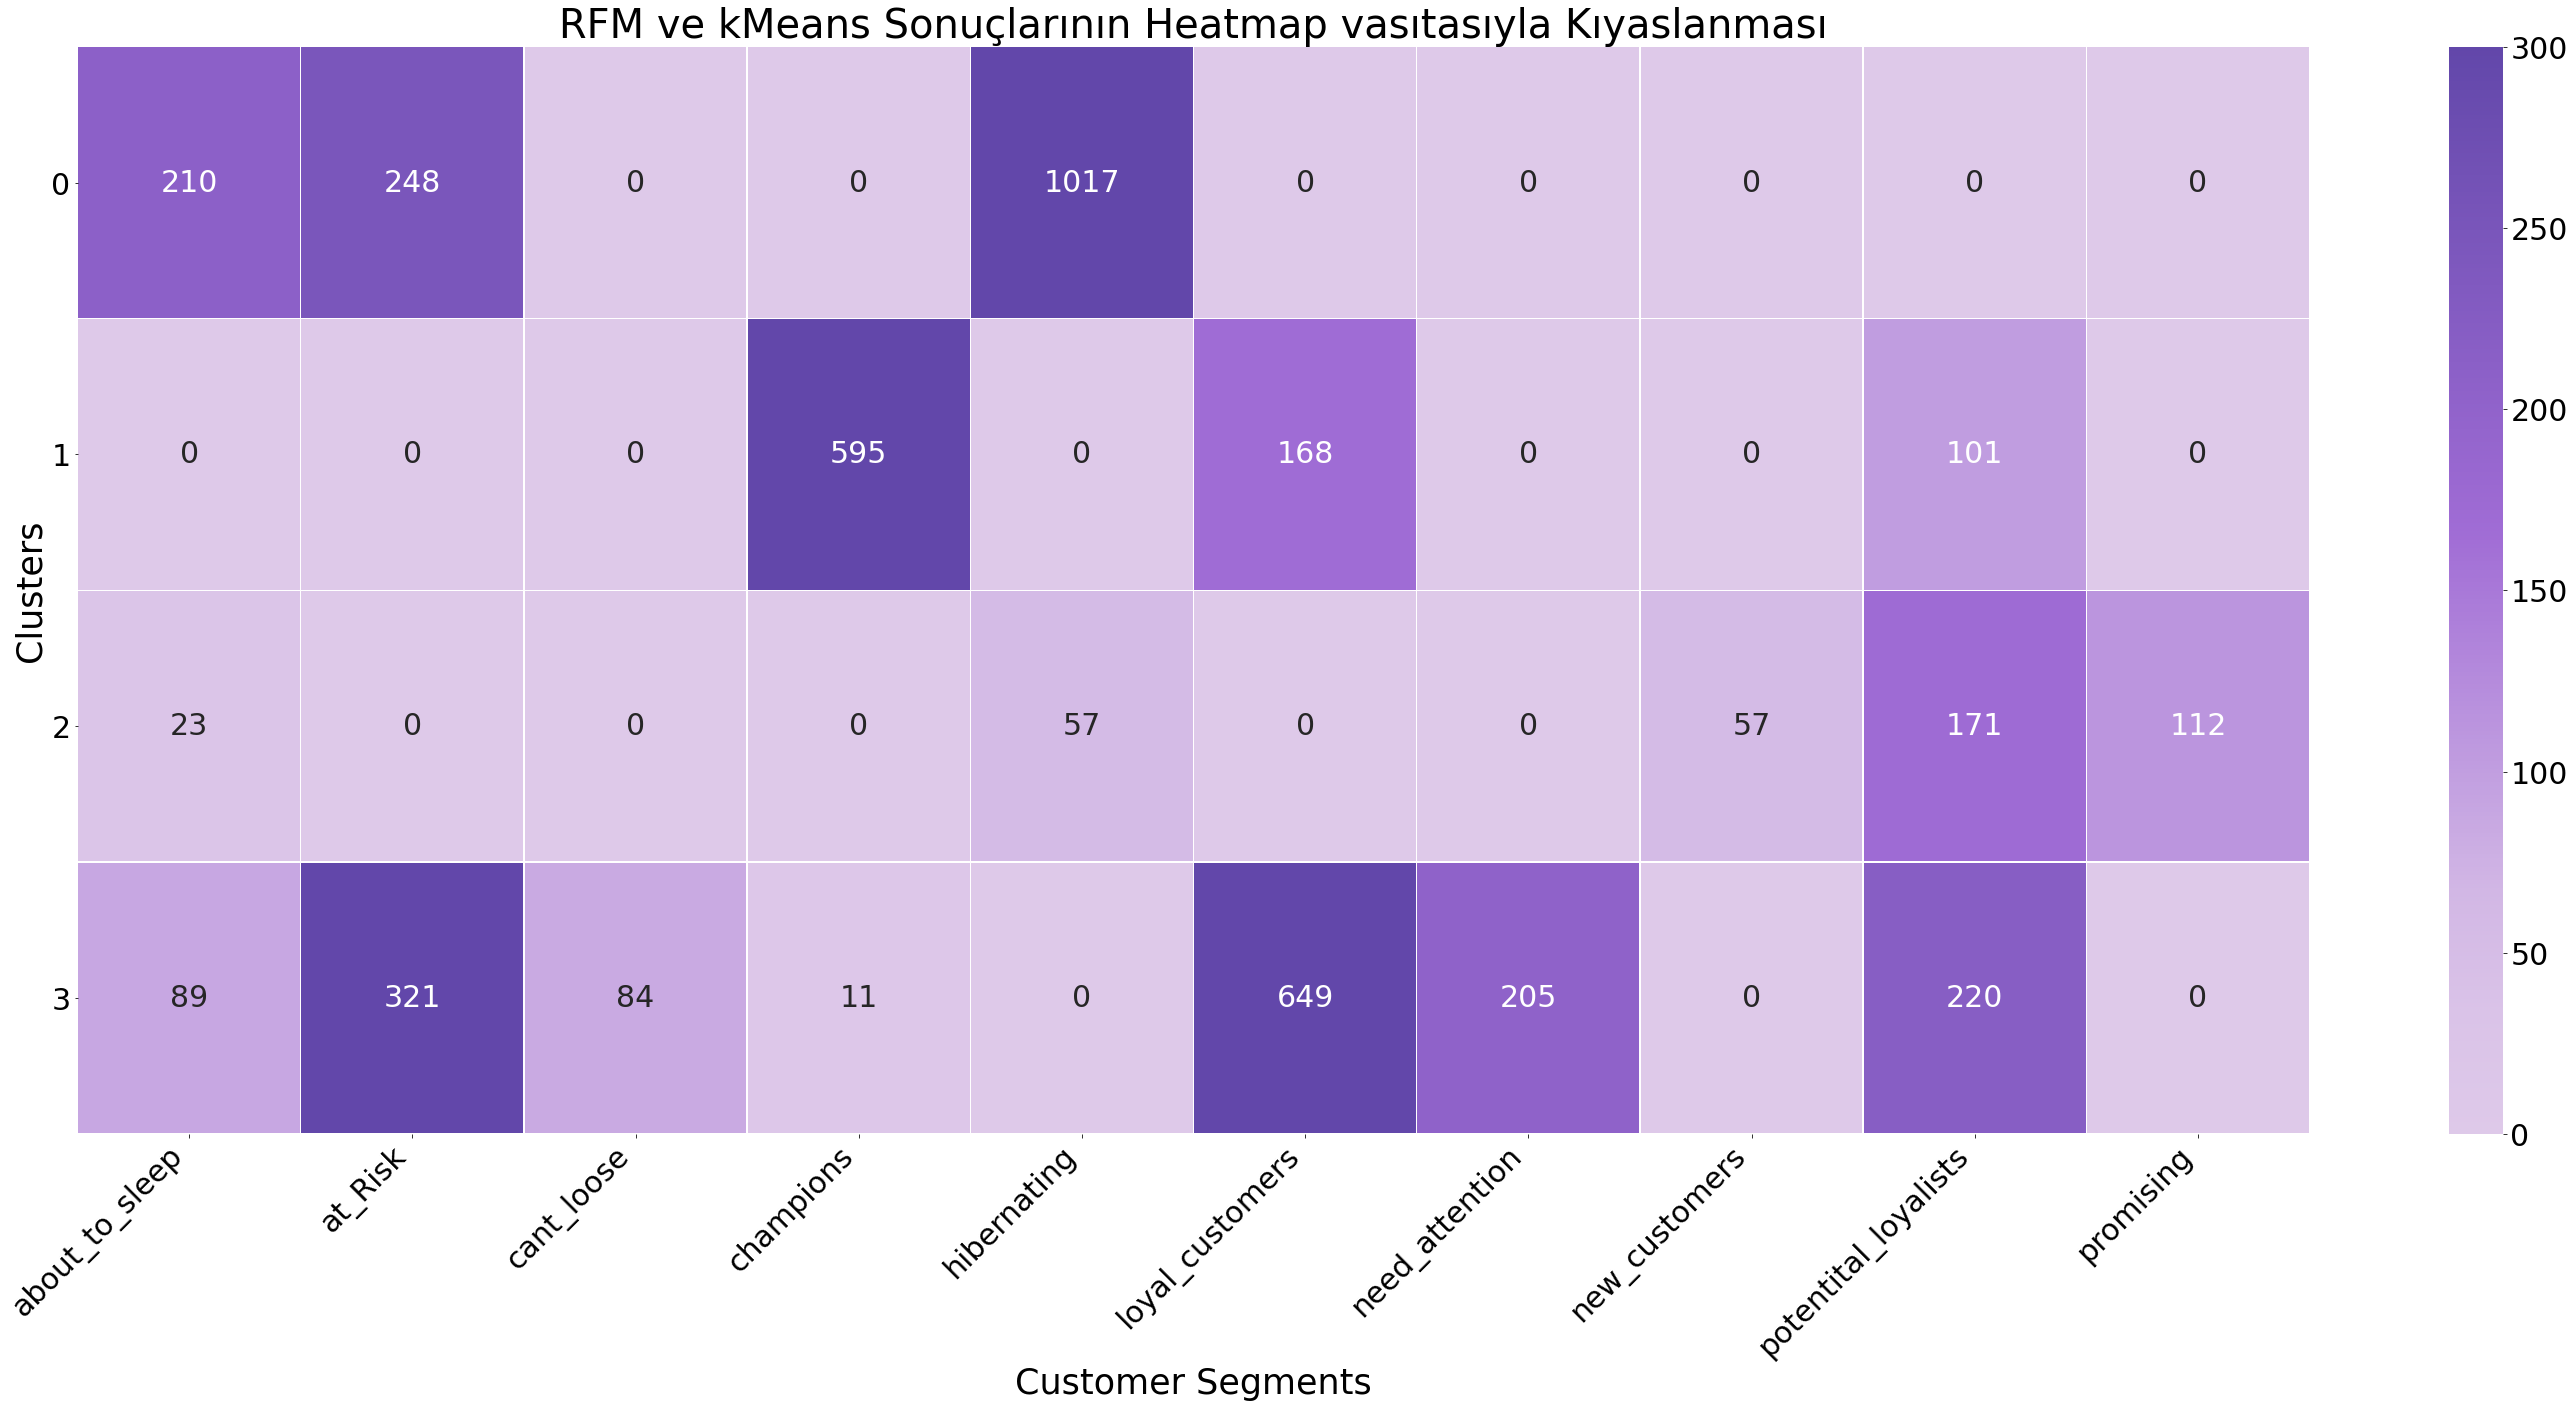

In [45]:
#RMF ve kMeans Sonuçlarının Kıyaslanamsı
cmap = LinearSegmentedColormap.from_list(name='tmp',
                                         colors=["#dec9e9", "#dac3e8", "#d2b7e5", "#c19ee0", "#b185db",
                                                  "#a06cd5", "#9163cb", "#815ac0", "#7251b5", "#6247aa"])

names = ["about_to_sleep", "at_Risk", "cant_loose", "champions", "hibernating", 
"loyal_customers", "need_attention", "new_customers", "potentital_loyalists", "promising"]

df3 = (pd.merge(df_log, df_rfm, left_on = 'Customer ID', right_on = 'Customer ID', how = 'inner'))

pivot = df3.pivot_table(index = ['cluster'], values = ['Customer ID'],
                       columns = 'customer_segment', aggfunc = 'count', fill_value = 0).reset_index()

pivot = pivot.drop(columns = ["cluster"])

f, ax = plt.subplots(figsize = (50, 20))
sns.heatmap(pivot, cmap = cmap, xticklabels = names, linewidths = 0.5, annot = True, fmt = 'g', 
            annot_kws = {'size' : 30}, vmax = 300)

plt.yticks(rotation = 0, ha = 'right', fontsize=30)
plt.xticks(rotation = 45, ha = 'right', fontsize=30)

plt.ylabel('Clusters', fontsize = 35)
plt.xlabel('Customer Segments', fontsize = 35)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = 30)

ax.set_title('RFM ve kMeans Sonuçlarının Heatmap vasıtasıyla Kıyaslanması', fontsize = 40)